<a href="https://colab.research.google.com/github/SemenutaEgor/ml_homework/blob/master/hw1_homicide_reports.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание задачи
Есть данные о 638454 убийствах в США в период с 1980 по 2014 год. Каждый отчёт включает в себя такие признаки:
<ol>
    <li>Номер записи</li>
    <li>Код, название и тип агенства</li>
    <li>Город и штат</li>
    <li>Год и месяц</li>
    <li>Инцидент (количество)</li>
    <li>Тип преступления</li>
    <li>Раскрыто преступление или нет</li>
    <li>Пол, возраст, раса и этническая принадлежность жертвы</li>
    <li>Пол, возраст, раса и этническая принадлежность преступника</li>
    <li>Отношения между преступником и жертвой</li>
    <li>Оружие</li>
    <li>Количество жертв и преступников</li>
    <li>Источник отчёта</li>
</ol>

Задача такая: определить было ли дело раскрыто.

# Прочитаем данные

Загружаем нужные библиотеки

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns           
import sklearn   

In [ ]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"egorsemenuta","key":"59b2ac75bf5f577692b3d5b6fbf5424e"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d murderaccountability/homicide-reports

  0% 0.00/9.83M [00:00<?, ?B/s]
100% 9.83M/9.83M [00:00<00:00, 89.7MB/s]


In [ ]:
!ls

homicide-reports.zip  kaggle.json  sample_data


In [ ]:
!unzip homicide-reports.zip

Archive:  homicide-reports.zip
  inflating: database.csv            


In [ ]:
data = pd.read_csv("database.csv", low_memory = False, sep = ',')

In [ ]:
data.shape

(638454, 24)

Немного обрежем, иначе потом не хватает RAM для вычислений.

In [ ]:
rows_to_drop = data[(data['Record ID'] > 100000)].index

In [ ]:
data = data.drop(rows_to_drop)
data.shape

(100000, 24)

In [ ]:
del data['Record ID']
del data['Agency Code']
del data['Agency Name']
del data['State']
del data['Year']

In [ ]:
data.shape

(100000, 19)

# Визуализация данных и вычисление основных характеристик

Таблица:

In [ ]:
data

,Agency Type,City,Month,Incident,Crime Type,Crime Solved,Victim Sex,Victim Age,Victim Race,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,Municipal Police,Anchorage,January,1,Murder or Manslaughter,Yes,Male,14,Native American/Alaska Native,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,Municipal Police,Anchorage,March,1,Murder or Manslaughter,Yes,Male,43,White,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,Municipal Police,Anchorage,March,2,Murder or Manslaughter,No,Female,30,Native American/Alaska Native,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,Municipal Police,Anchorage,April,1,Murder or Manslaughter,Yes,Male,43,White,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,Municipal Police,Anchorage,April,2,Murder or Manslaughter,No,Female,30,Native American/Alaska Native,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Municipal Police,Jackson,July,1,Murder or Manslaughter,Yes,Male,22,Black,Not Hispanic,Male,22,Black,Not Hispanic,Acquaintance,Handgun,0,0,FBI
99996,Sheriff,Jasper,September,1,Murder or Manslaughter,Yes,Male,32,White,Hispanic,Male,21,White,Hispanic,Acquaintance,Shotgun,0,1,FBI
99997,Sheriff,Jefferson,March,1,Murder or Manslaughter,Yes,Female,23,White,Not Hispanic,Male,39,White,Not Hispanic,Stranger,Knife,0,0,FBI
99998,Sheriff,Jefferson,July,1,Murder or Manslaughter,Yes,Female,69,White,Not Hispanic,Male,19,White,Not Hispanic,Family,Knife,0,0,FBI


Признак **Crime Solved** - бинарный, признаки **Incident, Victim Age, Perpetdator Age, Victim Count,  Perpetdator Count** - числовые, остальные - номинальные (категориальные).

Нужно предсказать признак **Crime Solved** по остальным признакам - это задача классификации.

In [ ]:
data['Perpetrator Age'] = pd.to_numeric(data['Perpetrator Age'], errors='coerce')

In [ ]:
data.describe()

,Incident,Victim Age,Perpetrator Age,Victim Count,Perpetrator Count
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000
mean,13.464350,35.918050,22.39331,0.110400,0.145850
std,27.021051,34.634307,17.83843,0.546347,0.476928
min,1.000000,0.000000,0.00000,0.000000,0.000000
25%,1.000000,23.000000,0.00000,0.000000,0.000000
50%,2.000000,31.000000,23.00000,0.000000,0.000000
75%,10.000000,43.000000,33.00000,0.000000,0.000000
max,994.000000,998.000000,99.00000,9.000000,10.000000


In [ ]:
data.describe(include=['object'])

,Agency Type,City,Month,Crime Type,Crime Solved,Victim Sex,Victim Race,Victim Ethnicity,Perpetrator Sex,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Record Source
count,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000
unique,7,1574,12,2,2,3,5,3,3,5,3,28,16,1
top,Municipal Police,New York,August,Murder or Manslaughter,Yes,Male,White,Not Hispanic,Male,White,Unknown,Unknown,Handgun,FBI
freq,76131,8352,9070,98753,73271,76942,54273,59443,63009,37051,45625,31681,45749,100000


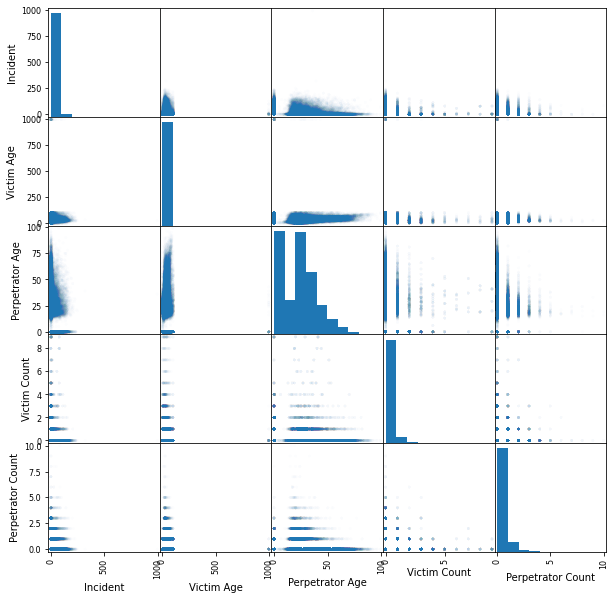

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(data, alpha = .01, figsize = (10, 10))
pass

In [ ]:
data['Victim Age'].quantile([0.005, .01, .05, .1, .5, .9, .95, .995])

0.005     0.0
0.010     0.0
0.050    15.0
0.100    18.0
0.500    31.0
0.900    60.0
0.950    71.0
0.995    99.0
Name: Victim Age, dtype: float64

In [ ]:
data['Perpetrator Age'].quantile([0.005, .01, .05, .1, .5, .9, .95, .995])

0.005     0.0
0.010     0.0
0.050     0.0
0.100     0.0
0.500    23.0
0.900    45.0
0.950    54.0
0.995    74.0
Name: Perpetrator Age, dtype: float64

#Интерпретация

Обычно жертва - это белый мужчина от 22 до 42 лет, преступник - белый мужчина в возрасте от 20 до 31 года. Самое популярно орудие убийства - пистолет. Чаще всего преступления совершаются в Лос-Анджелесе.

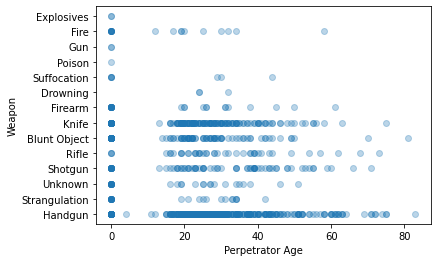

In [ ]:
np.random.seed(42)
random_subset = np.random.choice(np.arange(data.shape[0]), size=1000, replace=False)
plt.scatter(data.iloc[random_subset]['Perpetrator Age'], data.iloc[random_subset]['Weapon'], alpha = .3)
plt.xlabel('Perpetrator Age')
plt.ylabel('Weapon')
pass

По этой диаграмме рассеивания видно, что чем старше преступник, тем чаще он выбирает огнестрельное оружие

In [ ]:
corr_mat = data.corr()

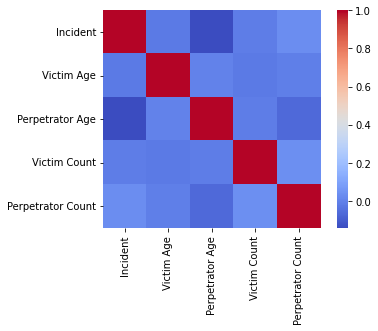

In [ ]:
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

Большой корелляции между признаками нет.

#Заполнение пропущенных значений

В нераскрытых делах возраст преступника указан как 0. И в некоторых делах возраст жертвы указан как 0. Будем считать это тоже пропущенными значениями и заполним из медианой.

In [ ]:
data['Victim Age'] = data['Victim Age'].replace(0, data['Victim Age'].median()) 
data['Perpetrator Age'] = data['Perpetrator Age'].replace(0, data['Perpetrator Age'].median()) 

#Обработаем категориальные признаки

In [ ]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
print(categorical_columns)
print(numerical_columns)

['Agency Type', 'City', 'Month', 'Crime Type', 'Crime Solved', 'Victim Sex', 'Victim Race', 'Victim Ethnicity', 'Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Ethnicity', 'Relationship', 'Weapon', 'Record Source']
['Incident', 'Victim Age', 'Perpetrator Age', 'Victim Count', 'Perpetrator Count']


In [ ]:
data_describe = data.describe(include = [object])
for c in categorical_columns:
    data[c] = data[c].fillna(data_describe[c]['top'])

Бинарные:

In [ ]:
binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
print(binary_columns, nonbinary_columns)

['Crime Type', 'Crime Solved'] ['Agency Type', 'City', 'Month', 'Victim Sex', 'Victim Race', 'Victim Ethnicity', 'Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Ethnicity', 'Relationship', 'Weapon']


In [ ]:
data['Crime Type'] = pd.factorize(data['Crime Type'])[0]
data['Crime Solved'] = pd.factorize(data['Crime Solved'])[0]
data['Record Source'] = pd.factorize(data['Record Source'])[0]

Небинарные:

In [ ]:
data[nonbinary_columns]

,Agency Type,City,Month,Victim Sex,Victim Race,Victim Ethnicity,Perpetrator Sex,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon
0,Municipal Police,Anchorage,January,Male,Native American/Alaska Native,Unknown,Male,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object
1,Municipal Police,Anchorage,March,Male,White,Unknown,Male,White,Unknown,Acquaintance,Strangulation
2,Municipal Police,Anchorage,March,Female,Native American/Alaska Native,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
3,Municipal Police,Anchorage,April,Male,White,Unknown,Male,White,Unknown,Acquaintance,Strangulation
4,Municipal Police,Anchorage,April,Female,Native American/Alaska Native,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...
99995,Municipal Police,Jackson,July,Male,Black,Not Hispanic,Male,Black,Not Hispanic,Acquaintance,Handgun
99996,Sheriff,Jasper,September,Male,White,Hispanic,Male,White,Hispanic,Acquaintance,Shotgun
99997,Sheriff,Jefferson,March,Female,White,Not Hispanic,Male,White,Not Hispanic,Stranger,Knife
99998,Sheriff,Jefferson,July,Female,White,Not Hispanic,Male,White,Not Hispanic,Family,Knife


In [ ]:
data_nonbinary = pd.get_dummies(data[nonbinary_columns])
print(data_nonbinary.columns)

Index(['Agency Type_County Police', 'Agency Type_Municipal Police',
       'Agency Type_Regional Police', 'Agency Type_Sheriff',
       'Agency Type_Special Police', 'Agency Type_State Police',
       'Agency Type_Tribal Police', 'City_Abbeville', 'City_Acadia',
       'City_Accomack',
       ...
       'Weapon_Firearm', 'Weapon_Gun', 'Weapon_Handgun', 'Weapon_Knife',
       'Weapon_Poison', 'Weapon_Rifle', 'Weapon_Shotgun',
       'Weapon_Strangulation', 'Weapon_Suffocation', 'Weapon_Unknown'],
      dtype='object', length=1659)


#Нормализация признаков

In [ ]:
data_numerical = data[numerical_columns]
data_numerical.describe()

,Incident,Victim Age,Perpetrator Age,Victim Count,Perpetrator Count
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,13.464350,36.247580,29.042150,0.110400,0.145850
std,27.021051,34.437911,11.364192,0.546347,0.476928
min,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,23.000000,23.000000,0.000000,0.000000
50%,2.000000,31.000000,23.000000,0.000000,0.000000
75%,10.000000,43.000000,33.000000,0.000000,0.000000
max,994.000000,998.000000,99.000000,9.000000,10.000000


In [ ]:
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)
data_numerical.describe()

,Incident,Victim Age,Perpetrator Age,Victim Count,Perpetrator Count
count,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05,1.000000e+05
mean,1.245795e-15,1.170301e-15,-3.243413e-15,-4.855983e-15,8.437498e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-4.612830e-01,-1.023511e+00,-2.467588e+00,-2.020695e-01,-3.058115e-01
25%,-4.612830e-01,-3.846801e-01,-5.316832e-01,-2.020695e-01,-3.058115e-01
50%,-4.242748e-01,-1.523780e-01,-5.316832e-01,-2.020695e-01,-3.058115e-01
75%,-1.282093e-01,1.960752e-01,3.482738e-01,-2.020695e-01,-3.058115e-01
max,3.628784e+01,2.792714e+01,6.155990e+00,1.627098e+01,2.066173e+01


In [ ]:
data = pd.concat((data_numerical, data_nonbinary, data[binary_columns]), axis = 1)
print(data.shape)

(100000, 1666)


In [ ]:
# data.to_csv('normdata.csv', sep = ',')

#Отбор признаков

In [ ]:
X = data.drop('Crime Solved', axis = 1) 
y = data['Crime Solved']
feature_names = X.columns

In [ ]:
# X.to_csv('X.csv', sep = ',')
# y.to_csv('y.csv', sep = ',')

#Обучаем модель

In [ ]:
# X = pd.read_csv("X.csv", low_memory = False, sep = ',')

In [ ]:
# y = pd.read_csv("y.csv", low_memory = False, sep = ',')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

70000 30000


### KNN

Попробуем сначала для 3 соседей:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNN

knn = KNN(n_neighbors = 3)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

Посмотрим точность

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, KNN(n_neighbors = 3).fit(X_train, y_train).predict(X_test))

0.9972

Посмотрим какое количество соседей может быть лучше

In [ ]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors': range(1, 10)}
grid_searcher = GridSearchCV(knn, params, cv=5)
grid_searcher.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=3, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': range(1, 10)}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None, verbose=0)

In [ ]:
df = pd.DataFrame(grid_searcher.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,21.356501,2.050110,1184.802443,21.703401,1,{'n_neighbors': 1},0.998571,0.997214,0.998357,0.998214,0.997929,0.998057,0.000470,3
1,21.092691,0.797513,1374.233133,18.095802,2,{'n_neighbors': 2},0.998643,0.998143,0.998714,0.998714,0.998714,0.998586,0.000223,1
2,20.612842,0.580464,1477.194785,38.911746,3,{'n_neighbors': 3},0.997500,0.997214,0.998143,0.998071,0.998286,0.997843,0.000413,5
3,20.940052,0.722164,1518.887533,10.338164,4,{'n_neighbors': 4},0.998000,0.997500,0.998500,0.998286,0.998786,0.998214,0.000440,2
4,22.775498,0.772624,1612.225015,12.981732,5,{'n_neighbors': 5},0.997286,0.996357,0.998143,0.997643,0.998143,0.997514,0.000663,7
5,21.749219,0.428582,1627.430684,6.159302,6,{'n_neighbors': 6},0.997929,0.997286,0.998429,0.998143,0.998214,0.998000,0.000391,4
6,19.866465,0.310707,1621.821756,7.129073,7,{'n_neighbors': 7},0.997429,0.996714,0.997857,0.997429,0.997929,0.997471,0.000432,8
7,19.826744,0.114224,1637.722710,6.189315,8,{'n_neighbors': 8},0.997643,0.996786,0.998071,0.997714,0.998143,0.997671,0.000484,6
8,19.555843,0.291480,1642.636249,15.010619,9,{'n_neighbors': 9},0.997286,0.996143,0.997571,0.997571,0.997929,0.997300,0.000613,9


In [ ]:
means = df['mean_test_score']
stds = df['std_test_score']
n_neighbors = df['params'].apply(lambda x: x['n_neighbors'])

In [1]:
plt.figure(figsize=(18, 8))
plt.plot(n_neighbors, means)
# plt.fill_between(range(len(means)), means + stds, means - stds, alpha = )
plt.xlim(1, 10)
plt.ylim(0.98, 1)
# plt.xticks(np.arange(1, n, 2))
plt.xlabel('Количество соседей')
plt.ylabel('Accuracy')
plt.grid()

NameError: ignored